# Darks Souls II Reviews (2023)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Steam Reviews as of 12/18/23:

In [2]:
df = pd.read_csv('reviews.csv')
reviews = df.copy()
reviews.head()

,Unnamed: 0,SteamId,Review,Recommended?,DatePosted
0,0,Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,"Posted: June 2, 2017"
1,1,76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
2,2,76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
3,3,76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
4,4,76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


## Data Cleaning/Wrangling:

In [3]:
reviews.drop(columns={'Unnamed: 0'}, inplace=True)
reviews.set_index('SteamId', inplace=True)
reviews.head()

,Review,Recommended?,DatePosted
SteamId,,,
Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,"Posted: June 2, 2017"
76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


Just getting the dates in DatePosted:

In [4]:
dates = [re.compile(r'Posted:|,').sub(' ', date).strip() for date in reviews.DatePosted]
dates = [re.compile(r' +').sub(' ', date).strip() for date in dates]
reviews.DatePosted = dates
reviews[['DatePosted']].head()

,DatePosted
SteamId,
Xilirite,June 2 2017
76561197996536125,June 20 2021
76561198143997912,August 12
76561198088449870,July 4
76561198960403801,April 30 2022


Seperating the 'DatePosted' column year column:
- There are some entries that don't have years (will investigate later)

In [5]:
reviews['Date'] = pd.to_datetime(reviews.DatePosted, errors='coerce')
reviews['Year'] = reviews['Date'].dt.strftime('%Y')
reviews.drop(columns={'DatePosted', 'Date'}, inplace=True)
reviews

,Review,Recommended?,Year
SteamId,,,
Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,2017
76561197996536125,Elden Ring waiting room,Recommended,2021
76561198143997912,I thought this was supposed to be the bad one,Recommended,NaN
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,NaN
76561198960403801,port bloodborne to pc,Recommended,2022
...,...,...,...
saihchotic,Game's so hard steam wont even let me redownlo...,Recommended,2017
TheArmedMadMan,This game is wank. It's basically Dark Souls b...,Not Recommended,2017
76561197971446226,Flawed camera but one of the best games I've e...,Recommended,2017


In [6]:
reviews.Year.isna().sum()

4736

Cleaning up the reviews:

In [7]:
from nltk.corpus import stopwords
from textblob import TextBlob

- Fixing misspellings:

In [8]:
from autocorrect import Speller

spell = Speller(lang='en')

In [9]:
# r = [spell(review) if pd.notna(review) else review for review in reviews.Review]

- Removing anything that's not a letter (urls, esc seqs, etc.):

In [10]:
# Removing urls:
r = [re.sub(r'http\S+', '', review).lower().strip() if pd.notna(review) else review for review in reviews.Review]

# Removing esc sequences, punctuation, and numbers:
    # There's some ASCII art in some of the reviews
r = [re.sub(r'[^A-Za-z]', ' ', review).strip() if pd.notna(review) else review for review in r]

# Removing stop words:
stop_wrds = re.compile(''.join([rf'\b{wrd}\b|' for wrd in stopwords.words('english')]))
r = [re.sub(stop_wrds, '', review).strip() if pd.notna(review) else review for review in r]

# Removing multiple and trailiing whitespaces:
r = [re.sub(r' +', ' ', review).strip() if pd.notna(review) else review for review in r]

reviews['Review'] = r

In [11]:
reviews.dtypes

Review          object
Recommended?    object
Year            object
dtype: object

In [12]:
reviews.describe()

,Review,Recommended?,Year
count,35082,35178,30442
unique,28606,2,8
top,,Recommended,2021
freq,832,28603,7366


## EDA:

Distribution of whether or not people recommend buying the game:

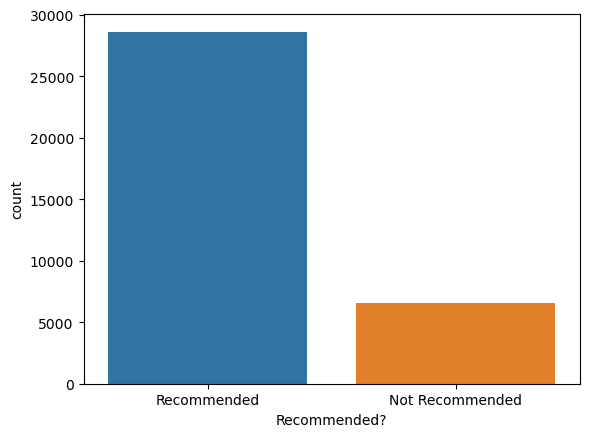

In [13]:
sns.barplot(data=reviews['Recommended?'].value_counts().reset_index(), 
            x='Recommended?',
            y='count');

- Most people recommend playing DS2

Years captured in the webscraped reviews:

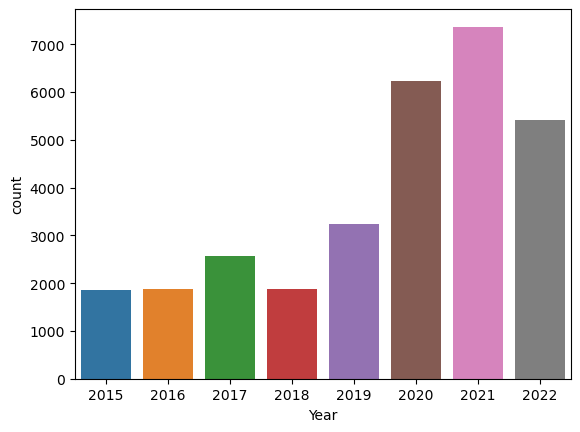

In [14]:
yr_dist = reviews.groupby('Year')['Recommended?'].count().reset_index()
yr_dist.rename(columns={'Recommended?':'count'}, inplace=True)

sns.barplot(data=yr_dist, 
            x='Year',
            y='count');

- Most reviews are fairly recent
    - Game released    : March 2014
    - Remaster released: April 2015 (focus of this project)

Proportions of those who don't and do recommend DS2 in each of the years:

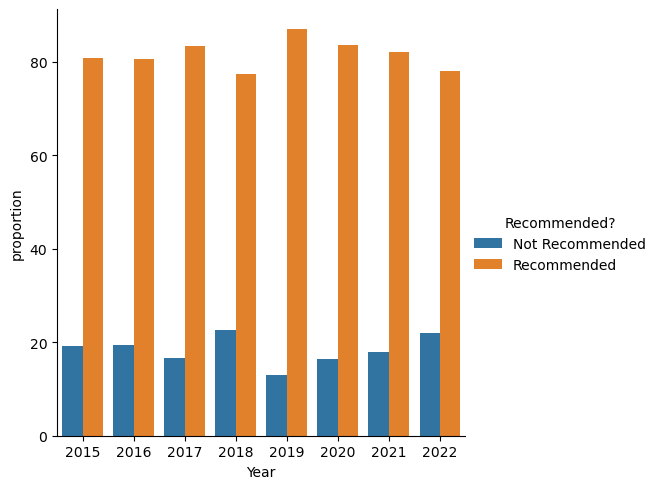

In [15]:
yr_plt = reviews.groupby(['Year', 'Recommended?']).count().reset_index()
yr_plt.rename(columns={'Review':'proportion'}, inplace=True)
yr_plt['proportion'] = 100 * (yr_plt['proportion'] / yr_plt.groupby(['Year'])['proportion'].transform('sum'))

sns.catplot(data=yr_plt,
            kind='bar',
            x='Year',
            y='proportion',
            hue='Recommended?'
            );

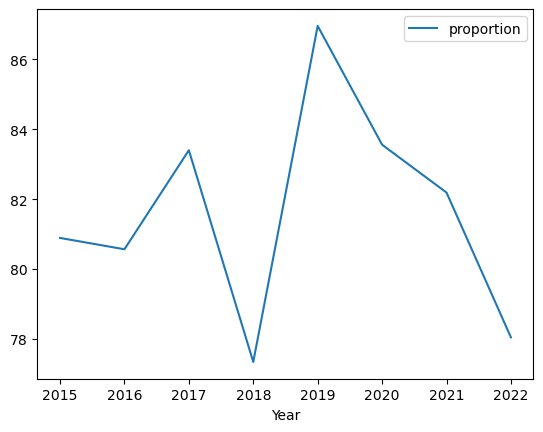

In [16]:
yr_plt[yr_plt['Recommended?'] == 'Recommended'].plot(kind='line',
                                                     x='Year',
                                                     y='proportion');

- Prior to contrary belief, the game was initially praised more than disliked during initial release
- Throughout the years, treatment of the game has been consistently positive

## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

For sake of analysis specifically on the actual reviews, drop any rows that have no reviews:

In [17]:
reviews = reviews.dropna(subset=['Review'])
reviews.shape

(35082, 3)

Top 10 Most Common Words in the Reviews:

In [18]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [20]:
review_txt = reviews.Review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()
tfidf_df.head()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


,aaa,aava,abandoned,abilities,ability,able,absolute,absolutely,absurd,abundance,...,youtube,yup,z,zallen,zelda,zero,zombie,zombies,zone,zones
0,0.0,0.052815,0.0,0.0,0.0,0.033266,0.0,0.032574,0.0,0.0,...,0.0,0.0,0.0,0.0,0.051972,0.0,0.0,0.0,0.114671,0.072039
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [21]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      1559
good      827
best      440
yes       349
dark      258
great     223
nice      219
git       204
gud       197
bad       193
Name: count, dtype: int64

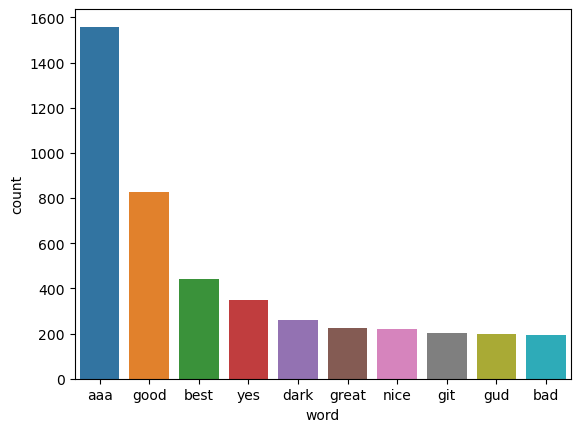

In [22]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            x='word',
            y='count');

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher
- Top words used seem to be positive, but this is looking at the words without context

Other popular words:

In [23]:
from wordcloud import WordCloud

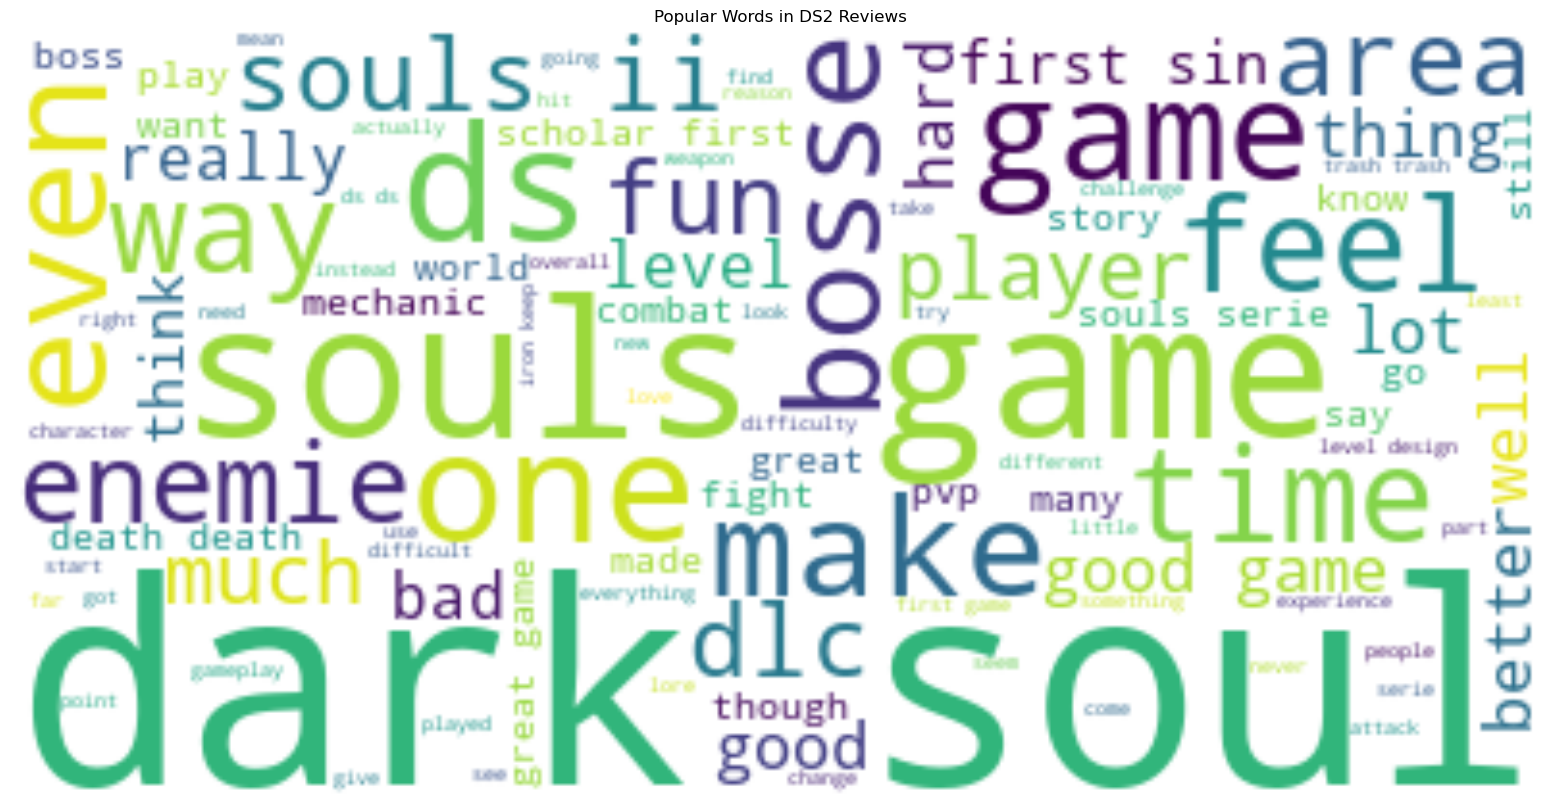

In [24]:
pop_wrds = " ".join( review for review in reviews.Review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate( pop_wrds )
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [25]:
pos_reviews = reviews[reviews['Recommended?'] == 'Recommended']
neg_reviews = reviews[reviews['Recommended?'] == 'Not Recommended']

In [26]:
pos_reviews.shape, neg_reviews.shape

((28521, 3), (6561, 3))

Function to display the output of the models:

In [27]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling, and uses CountVectorizer as input

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.Review).toarray()
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.Review).toarray()
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.Review).toarray()
neg_tf_feat_names = count_vector.get_feature_names_out()

In [30]:
lda = LatentDirichletAllocation(n_components=3, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [31]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,21672.0,game,22074.6,game,1607.4
1,souls,17193.4,souls,10003.6,hate,1480.6
2,dark,12348.5,like,7727.4,keep,913.1
3,good,6433.4,ds,7261.5,gud,854.3
4,first,4074.2,dark,6714.6,iron,720.9
5,still,4034.3,enemies,4699.1,die,654.0
6,ds,3944.5,bosses,4587.4,git,560.1
7,best,3750.0,get,4416.4,seek,495.5
8,games,3505.3,one,4354.6,sun,479.5
9,play,3188.0,even,3894.9,praise,473.8


- Interpreted topics that were identified:
    1. People saying how good the game is
    2. Bosses/enemies
    3. People expressing their likes or dislikes of the game

In [32]:
pos_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
pos_lda.fit(pos_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [33]:
display_topics(pos_lda, pos_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,2309.6,game,9479.3,game,20509.1
1,souls,2055.7,souls,4654.4,souls,13797.9
2,dark,1591.1,ds,4062.0,dark,9640.7
3,best,1518.2,like,3558.1,good,6434.3
4,love,1224.3,dark,3139.2,ds,4242.9
5,hate,1178.7,bosses,2675.4,still,3976.0
6,first,858.6,enemies,2389.1,games,3452.7
7,keep,789.3,get,2211.6,like,3384.3
8,gud,755.9,boss,2164.2,one,2980.5
9,scholar,719.0,one,2146.4,first,2916.3


- Interpreted topics that were identified:
    1. People expressing that they loved the game (expected since I'm looking at the subset of reviews that recommend the game)
    2. (similar to 1st topic)
    3. Bosses/enemies

In [34]:
neg_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
neg_lda.fit(neg_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [35]:
display_topics(neg_lda, neg_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,6075.0,game,6744.5,trash,1040.6
1,ds,2073.9,souls,5505.7,servers,347.4
2,like,1929.5,dark,4080.3,game,237.5
3,enemies,1419.8,like,1463.8,fromsoft,225.7
4,even,1359.3,play,1138.4,pc,208.2
5,get,1322.6,first,1135.1,controller,179.6
6,souls,1183.5,one,1133.5,turn,178.9
7,time,1079.4,games,996.9,product,165.5
8,one,1012.6,ds,925.2,fix,142.9
9,boss,945.5,good,872.0,online,132.5


- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

NMF: Linear algebra and uses the TF-IDF vectorizer as input

In [36]:
from sklearn.decomposition import NMF

In [37]:
nmf = NMF(n_components=3, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=3, random_state=42069)

In [38]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.3,good,4.9,game,3.5
1,dark,3.6,game,0.4,great,0.9
2,best,2.3,pretty,0.3,ds,0.8
3,games,0.4,still,0.1,fun,0.7
4,ii,0.4,yeah,0.0,like,0.6
5,series,0.3,souls,0.0,play,0.6
6,better,0.3,really,0.0,bad,0.6
7,still,0.3,yes,0.0,still,0.5
8,like,0.3,stuff,0.0,one,0.4
9,worst,0.3,luck,0.0,first,0.4


- Interpreted topics that were identified:
    1. Positive experiences from the game
    2. (similar to 1st topic)
    3. Mixed reception of the game (love and hate)

In [39]:
pos_txt = pos_reviews.Review.values.flatten()
pos_tfidf_array = tfidf.fit_transform(pos_txt).toarray()
nmf.fit(pos_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [40]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.1,good,4.8,game,3.5
1,dark,3.4,game,0.4,great,1.1
2,best,2.5,pretty,0.2,fun,0.8
3,games,0.4,still,0.1,ds,0.7
4,series,0.4,yeah,0.0,like,0.5
5,ii,0.3,souls,0.0,still,0.5
6,better,0.3,really,0.0,play,0.5
7,still,0.3,get,0.0,love,0.5
8,like,0.3,stuff,0.0,hate,0.4
9,one,0.3,actually,0.0,first,0.4


- Interpreted topics that were identified:
    1. Positive outloooks on the game
    2. similar to 1st topic
    3. People expressing their opinion on the game, ranging from good to bad

In [41]:
neg_txt = neg_reviews.Review.values.flatten()
neg_tfidf_array = tfidf.fit_transform(neg_txt).toarray()
nmf.fit(neg_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [42]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,2.1,bad,3.2,souls,2.7
1,ds,0.8,game,0.7,dark,2.5
2,like,0.7,really,0.1,worst,0.5
3,play,0.6,design,0.1,play,0.3
4,good,0.5,kinda,0.0,instead,0.2
5,one,0.5,souls,0.0,ii,0.2
6,get,0.5,port,0.0,games,0.2
7,even,0.5,hitboxes,0.0,like,0.2
8,enemies,0.4,buy,0.0,buy,0.2
9,time,0.4,darksouls,0.0,series,0.2


- Interpreted topics that were identified:
    1. Vague but concerned w/ enemies
    2. Very negative perspectives on the game
    3. Negative experience regarding bosses, hitboxes, and game design

## Conclusion: